<a href="https://colab.research.google.com/github/taylorfrancisco/Example-Work/blob/main/NLP_Frankenstein_Dracula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up


In [ ]:
import pandas as pd
import numpy as np
import glob
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
#!pip install shorttext
#import shorttext
#from shorttext.utils import standard_text_preprocessor_1
#from shorttext.utils import DocumentTermMatrix
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.regression.linear_model import OLS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
from scipy.cluster.hierarchy import ward, dendrogram

In [ ]:
# upload Frankenstein text
from google.colab import files
uploaded= files.upload()

In [ ]:
# upload Dracula text
from google.colab import files
uploaded= files.upload()

In [ ]:
# read lines command
files = ['Frankenstein.txt','Dracula.txt']
paperwords = []
for d in files:
    with open( str(d), encoding = 'latin1') as nf:
        lines = nf.readlines()

    i = 1
    for x in lines:
        words = x.split()
        for w in words:
            paperwords.append([d, i, w])

        i += 1

For this assignment, I am interested in how the novels of Dracula by Bram Stoker and Frankenstein by Mary Shelley compare to each other. There are a number of big differences between the novels, two main ones being sex of the author and date written (Dracula 1897 and Frankenstein in 1818). Another notable difference is narrative structure, where Dracula uses perspectives from a wide variety of sources and Frankenstein goes back and forth between the perspective of Frankenstein and the perspective of the monster. In theory Dracula would be more widely varied in sentiment and word choice throughout the novel where there may be consistent flipping back and forth between sentiment in Frankenstein indicating the two different perspectives of Frankenstein and his monsterl

There are also some similarities in that they are both paranormal books about non-human creatures. I am interested to see what kind of simialarities and differences appear in the words used in each novel.

# Preprocessing

In [ ]:
#make a dataframe of words
ppwords = pd.DataFrame(paperwords, columns = ['book', 'line', 'word'])

In [ ]:
# verify dataframe
ppwords

,book,line,word
0,Frankenstein.txt,1,ï»¿The
1,Frankenstein.txt,1,Project
2,Frankenstein.txt,1,Gutenberg
3,Frankenstein.txt,1,eBook
4,Frankenstein.txt,1,of
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


In [ ]:
#remove non-asii characters that seemed to have appeared
ppwords['word'] = ppwords['word'].str.encode('ascii', 'ignore').str.decode('ascii')

In [ ]:
#verify non-asii characters are gone
ppwords

,book,line,word
0,Frankenstein.txt,1,The
1,Frankenstein.txt,1,Project
2,Frankenstein.txt,1,Gutenberg
3,Frankenstein.txt,1,eBook
4,Frankenstein.txt,1,of
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


## Remove numbers


In [ ]:
ppwords['word'] = ppwords['word'].str.replace('\d+', '')

<ipython-input-7-56a5950e430f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  ppwords['word'] = ppwords['word'].str.replace('\d+', '')


In [ ]:
ppwords

,book,line,word
0,Frankenstein.txt,1,The
1,Frankenstein.txt,1,Project
2,Frankenstein.txt,1,Gutenberg
3,Frankenstein.txt,1,eBook
4,Frankenstein.txt,1,of
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


## Remove punctuation and white space

In [ ]:
ppwords["word"] = ppwords['word'].str.replace('[^\w\s]','', regex='True')

In [ ]:
#remove underscores
ppwords['word'] = ppwords['word'].str.replace('_', '')


## Remove Uppercase

In [ ]:
ppwords['word'] = ppwords['word'].str.lower()

In [ ]:
#verify capitals are removed
ppwords

,book,line,word
0,Frankenstein.txt,1,the
1,Frankenstein.txt,1,project
2,Frankenstein.txt,1,gutenberg
3,Frankenstein.txt,1,ebook
4,Frankenstein.txt,1,of
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


## Removing Irrelevant Metadata

In [ ]:
#drop lines from the disclaimer from the guttenburg project from frankenstein text

ppwords = ppwords.drop(ppwords.index[range(219)])


In [ ]:
#verify dataframe starts with beginning of book

ppwords

,book,line,word
219,Frankenstein.txt,72,letter
220,Frankenstein.txt,72,
221,Frankenstein.txt,74,to
222,Frankenstein.txt,74,mrs
223,Frankenstein.txt,74,saville
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


In [ ]:
#subset to Dracula to identify which lines are from the gutenberg disclaimer
ppwords[(ppwords['book'] == 'Dracula.txt')]

,book,line,word
78098,Dracula.txt,1,the
78099,Dracula.txt,1,project
78100,Dracula.txt,1,gutenberg
78101,Dracula.txt,1,ebook
78102,Dracula.txt,1,of
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


In [ ]:
#drop lines from the disclaimer from the guttenburg project from dracula text
ppwords= ppwords.drop(labels=range(78098, 78504), axis=0)

In [ ]:
#verify dataframe starts with beginning of book
ppwords[(ppwords['book'] == 'Dracula.txt')]

,book,line,word
78504,Dracula.txt,115,jonathan
78505,Dracula.txt,115,harkers
78506,Dracula.txt,115,journal
78507,Dracula.txt,117,kept
78508,Dracula.txt,117,in
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


In [ ]:
#identify where the end of the book is and where end-disclaimers begin
ppwords.tail(4000)

,book,line,word
238561,Dracula.txt,15348,the
238562,Dracula.txt,15348,throat
238563,Dracula.txt,15348,whilst
238564,Dracula.txt,15348,at
238565,Dracula.txt,15348,the
...,...,...,...
242556,Dracula.txt,15869,to
242557,Dracula.txt,15869,hear
242558,Dracula.txt,15869,about
242559,Dracula.txt,15869,new


In [ ]:
# remove end of book disclaimers from Dracula text

ppwords= ppwords.drop(labels=range(239314, 242561), axis=0)



In [ ]:
#verify that the end of dataframe is now the end of Dracula text
ppwords

,book,line,word
219,Frankenstein.txt,72,letter
220,Frankenstein.txt,72,
221,Frankenstein.txt,74,to
222,Frankenstein.txt,74,mrs
223,Frankenstein.txt,74,saville
...,...,...,...
239309,Dracula.txt,15429,sake
239310,Dracula.txt,15431,jonathan
239311,Dracula.txt,15431,harker
239312,Dracula.txt,15433,the


In [ ]:
#locate where end-disclaimer is for the Frankenstein text
ppwords[(ppwords['book'] == 'Frankenstein.txt')].tail(3000)

,book,line,word
75098,Frankenstein.txt,7378,be
75099,Frankenstein.txt,7378,no
75100,Frankenstein.txt,7378,longer
75101,Frankenstein.txt,7378,felt
75102,Frankenstein.txt,7378,soon
...,...,...,...
78093,Frankenstein.txt,7737,to
78094,Frankenstein.txt,7737,hear
78095,Frankenstein.txt,7737,about
78096,Frankenstein.txt,7737,new


In [ ]:
# remove end of book disclaimers from Frankenstein text
ppwords= ppwords.drop(labels=range(75194, 78098), axis=0)


In [ ]:
#verify that end of Frankenstein subset is the end of the Frankenstein text
ppwords[(ppwords['book'] == 'Frankenstein.txt')].tail(3000)

,book,line,word
72194,Frankenstein.txt,7104,return
72195,Frankenstein.txt,7104,shamefully
72196,Frankenstein.txt,7104,my
72197,Frankenstein.txt,7104,purpose
72198,Frankenstein.txt,7104,unfulfilled
...,...,...,...
75189,Frankenstein.txt,7387,lost
75190,Frankenstein.txt,7387,in
75191,Frankenstein.txt,7387,darkness
75192,Frankenstein.txt,7387,and


## Removing Stop Words


In [ ]:
#download dictionary of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#make a list of the stopwords
stop_words = list(stopwords.words('english'))

In [ ]:
for word in ppwords["word"]: # iterate over word_list
  if word in stop_words:
    ppwords["word"] = ppwords["word"].replace(word, '') # replace word with blank if it is a stopword

In [ ]:
#verify that stop words are removed
ppwords

,book,line,word
219,Frankenstein.txt,72,letter
220,Frankenstein.txt,72,
221,Frankenstein.txt,74,
222,Frankenstein.txt,74,mrs
223,Frankenstein.txt,74,saville
...,...,...,...
239309,Dracula.txt,15429,sake
239310,Dracula.txt,15431,jonathan
239311,Dracula.txt,15431,harker
239312,Dracula.txt,15433,


In [ ]:
#label empty rows where stop words used to be as NAN
ppwords['word'].replace('', np.nan, inplace=True)

In [ ]:
#remove all rows with NAN
ppwords.dropna(subset=['word'], inplace=True)
ppwords

,book,line,word
219,Frankenstein.txt,72,letter
222,Frankenstein.txt,74,mrs
223,Frankenstein.txt,74,saville
224,Frankenstein.txt,74,england
225,Frankenstein.txt,77,st
...,...,...,...
239306,Dracula.txt,15429,much
239309,Dracula.txt,15429,sake
239310,Dracula.txt,15431,jonathan
239311,Dracula.txt,15431,harker


# Stem words

As these texts are literary in nature, there will be a lot of adjectives and plenty of variations on roots of words, which make it useful to stem the words to reduce somewhat meaningless variations on words (ie it makes sense for the analysis of comparing types of words between the two books if we consider words like "eating", "eats", or "eaten" to be one single word/idea of "eat".

In [ ]:
ps = PorterStemmer()
for w in ppwords['word']:
  (w, " : ", ps.stem(w))

ppwords['stem'] = ppwords['word'].apply(ps.stem)



In [ ]:
ppwords

,book,line,word,stem
219,Frankenstein.txt,72,letter,letter
222,Frankenstein.txt,74,mrs,mr
223,Frankenstein.txt,74,saville,savil
224,Frankenstein.txt,74,england,england
225,Frankenstein.txt,77,st,st
...,...,...,...,...
239306,Dracula.txt,15429,much,much
239309,Dracula.txt,15429,sake,sake
239310,Dracula.txt,15431,jonathan,jonathan
239311,Dracula.txt,15431,harker,harker


# Relative Word Frequency

In [ ]:
# create data frame with just book and stem
pw = ppwords[['book', 'stem']]

In [ ]:
pw

,book,stem
219,Frankenstein.txt,letter
222,Frankenstein.txt,mr
223,Frankenstein.txt,savil
224,Frankenstein.txt,england
225,Frankenstein.txt,st
...,...,...
239306,Dracula.txt,much
239309,Dracula.txt,sake
239310,Dracula.txt,jonathan
239311,Dracula.txt,harker


In [ ]:
# create dataframe with just book and stem that includes a count of times stem was used

d = pw.groupby(['book', 'stem']).size().reset_index(name='n')
d

,book,stem,n
0,Dracula.txt,aback,1
1,Dracula.txt,abaft,2
2,Dracula.txt,abandon,3
3,Dracula.txt,abas,1
4,Dracula.txt,abat,3
...,...,...,...
12099,Frankenstein.txt,younger,9
12100,Frankenstein.txt,youngest,1
12101,Frankenstein.txt,youngster,1
12102,Frankenstein.txt,youth,24


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object and fit it on the documents

vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(d['stem'])



In [ ]:
# create a countvectorizer that reflects how many times a word was used in each line of a book
dtm_df = pd.DataFrame(dtm.todense(),
                     index=d['book'],
                      columns=vectorizer.get_feature_names_out())
dtm_df

,aback,abaft,abandon,abas,abat,abbey,abe,abelderin,abhor,abhorr,...,youv,youwith,youy,yu,zeal,zealou,zolog,zoo,zophag,zophagi
book,,,,,,,,,,,,,,,,,,,,,
Dracula.txt,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dracula.txt,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dracula.txt,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dracula.txt,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dracula.txt,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Frankenstein.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Frankenstein.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Frankenstein.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#create a dataframe where the use of each word is summarized across lines so that the df reflects how many times a word
# is used in a book in total
new_df = dtm_df.groupby(dtm_df.index).sum()

In [ ]:
new_df

,aback,abaft,abandon,abas,abat,abbey,abe,abelderin,abhor,abhorr,...,youv,youwith,youy,yu,zeal,zealou,zolog,zoo,zophag,zophagi
book,,,,,,,,,,,,,,,,,,,,,
Dracula.txt,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
Frankenstein.txt,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#verify that the counts are accurate

new_df['evil']

book
Dracula.txt         1
Frankenstein.txt    1
Name: evil, dtype: int64

I noticed that the code given for the count vectorizer is not providing a true relative word frequency as it is only giving a binary of whether a word was ever used in the novel or not, not how many times a certain word was used in the novel. I found a solution online on how to accurately create these countvectorizers that requires creating a dataframe where the entire text is included in one cell. I am unsure how to reformat my data to be in this form, to accurately use the countvectorizer. As it stands, it is hard to make any conclusion about word choice between each novel besides the granular level of whether a word was used at all or not. This doesn't really give much insight into the differences between each text as there are several obvious reason why some words would be used in one and not another (ie locations or names). To find more interesting subtle differences would require being able to compare the true relative word frequency between texts.

# Most distinctive words for each book

In [ ]:
new_df_t = new_df.T

# Allow words to be a column instead of the index
new_df_t.reset_index(drop=False, inplace=True)
new_df_t.rename(columns={'index': 'words'}, inplace=True)
new_df_t


book,words,Dracula.txt,Frankenstein.txt
0,aback,1,0
1,abaft,1,0
2,abandon,1,1
3,abas,1,0
4,abat,1,0
...,...,...,...
9115,zealou,1,0
9116,zolog,1,0
9117,zoo,1,0
9118,zophag,1,0


In [ ]:
new_df_t['Frankenstein_prop'] = new_df_t['Frankenstein.txt'].apply(lambda x: x/new_df_t['Frankenstein.txt'].sum())
new_df_t['Dracula_prop'] = new_df_t['Dracula.txt'].apply(lambda x: x/new_df_t['Dracula.txt'].sum())

new_df_t['Frankenstein_over_Dracula'] = new_df_t.Frankenstein_prop - new_df_t.Dracula_prop

In [ ]:

new_df_t.sort_values('Frankenstein_over_Dracula', inplace=True)
new_df_t.head(10)

book,words,Dracula.txt,Frankenstein.txt,Frankenstein_prop,Dracula_prop,Frankenstein_over_Dracula
0,aback,1,0,0.0,0.000136,-0.000136
5086,moistur,1,0,0.0,0.000136,-0.000136
5085,moisten,1,0,0.0,0.000136,-0.000136
5084,mohc,1,0,0.0,0.000136,-0.000136
5083,moh,1,0,0.0,0.000136,-0.000136
5074,mockingli,1,0,0.0,0.000136,-0.000136
5071,mobil,1,0,0.0,0.000136,-0.000136
5070,moan,1,0,0.0,0.000136,-0.000136
5069,mme,1,0,0.0,0.000136,-0.000136
5067,mlast,1,0,0.0,0.000136,-0.000136


In [ ]:
new_df_t.reset_index(drop=True, inplace=True)

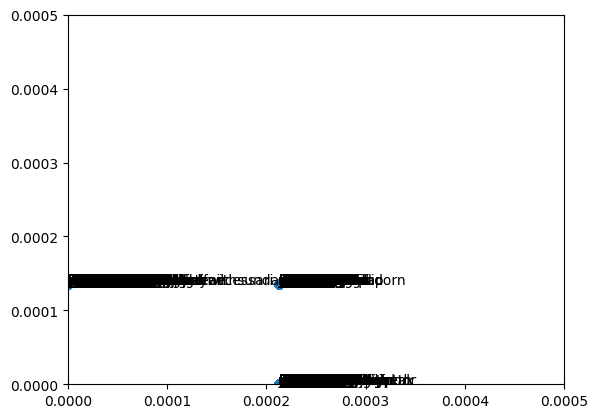

In [ ]:
fig, ax = plt.subplots()
plt.scatter(new_df_t.Frankenstein_prop, new_df_t.Dracula_prop)
plt.xlim(0, 0.0005)
plt.ylim(0, 0.0005)

for i, txt in enumerate(new_df_t.words):
    ax.annotate(txt, (new_df_t.Frankenstein_prop[i], new_df_t.Dracula_prop[i]))

Again, since the countvectorizer did not work for the format of my data, there is no valuable insights in comparing 'distinctive words' between texts as it will only produce words that were used in one and not the other. The binary nature of the data at this point is reflected in the above graph where all the words are clustered in two spaces where all the words have the exact proportion of either being used or not in one text or the other.

I suppose one interesting difference is the words "moistur" and "moisten" were used in Dracula and not in Frankenstein. Perhaps this is due to the focus on the mouth and blood in frankenstein that does not exist in Frankenstein.

# Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(new_df)

array([[1.        , 0.50359837],
       [0.50359837, 1.        ]])

# Chi Squared


In [ ]:
dtm_cont = pd.crosstab(new_df.T['Frankenstein.txt'], new_df.T['Dracula.txt'])

In [ ]:
chi2_stat, p_val, dof, ex = sp.stats.chi2_contingency(dtm_cont.values)
chi2_stat, p_val

(2012.868886734963, 0.0)

After preprocessing removing stop words and using stemmed words Dracula and Frankenstein have a cosine similarity of approximately 0.504, which indicates that they are fairly similar, but not vastly similar as the range is from 0 (perpendicular) to 1 (very similar). Similarly, according to the chi-squared test, Dracula and Frankenstein are not independent. This suggests that the word choice of these two texts are fairly similar and there is no large distinction between the two. Overall, this indicates that these two texts are not definitively distinct from each other and have a lot of overlap between the two.

# Sentiment Analysis


In [ ]:
# obtaining sentiment list from ntlk module and turning it into a dataframe
df_bing = pd.read_csv('bing.csv')

In [ ]:
#verify that sentiment df uploaded correctly
df_bing

,Unnamed: 0,word,sentiment
0,1,2-faces,negative
1,2,abnormal,negative
2,3,abolish,negative
3,4,abominable,negative
4,5,abominably,negative
...,...,...,...
6781,6782,zealously,negative
6782,6783,zenith,positive
6783,6784,zest,positive
6784,6785,zippy,positive


In [ ]:
#merge words from the two chosen text with the sentiment df
result = ppwords.merge(df_bing, on = 'word')

In [ ]:
#verify successful merge
result.head(-5)

,book,line,word,stem,Unnamed: 0,sentiment
0,Frankenstein.txt,80,rejoice,rejoic,4973,positive
1,Dracula.txt,1000,rejoice,rejoic,4973,positive
2,Dracula.txt,4114,rejoice,rejoic,4973,positive
3,Dracula.txt,8811,rejoice,rejoic,4973,positive
4,Dracula.txt,10334,rejoice,rejoic,4973,positive
...,...,...,...,...,...,...
16326,Dracula.txt,15168,downhill,downhil,1822,negative
16327,Dracula.txt,15225,lull,lull,3887,negative
16328,Dracula.txt,15231,blinding,blind,569,negative
16329,Dracula.txt,15243,glee,glee,2662,positive


In [ ]:
#change positive to be 1 and negative to -1 to allow for percentage calculations
result['sentiment'] = result['sentiment'].replace('positive', 1)
result['sentiment'] = result['sentiment'].replace('negative', -1)

In [ ]:
result['percentage'] = round(result['line'] / max(result['line']) *100/5)*5

NameError: ignored

In [ ]:
oFrankenstein = result[result['book'] == 'Frankenstein.txt']
oDracula = result.loc[result['book'] == 'Dracula.txt']


In [ ]:
oFrankensteina = oFrankenstein[['percentage', 'book', 'sentiment']].groupby('percentage')['sentiment'].sum()
oDraculaa = oDracula[['percentage', 'book', 'sentiment']].groupby('percentage')['sentiment'].sum()



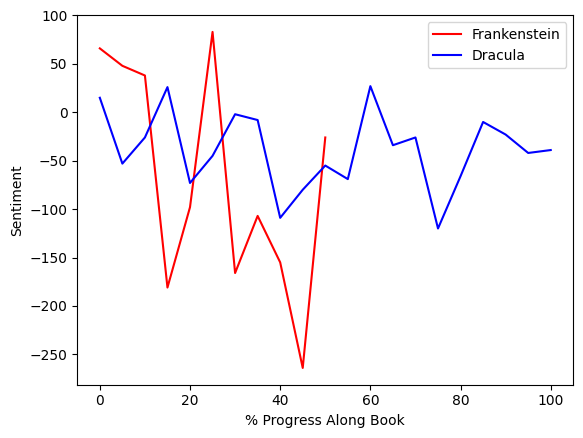

In [ ]:
#create dataframe of sentiment of two books across the length of the novel
from numpy import *
import math
import matplotlib.pyplot as plt

plt.plot(oFrankensteina, 'r', label = 'Frankenstein')
plt.plot(oDraculaa, 'b', label = 'Dracula')
plt.xlabel('% Progress Along Book')
plt.ylabel('Sentiment')



plt.legend()
plt.show()

 After pre-processing (stemming words and getting rid of stop words) I merged the words from each novel to a dataframe that classifies a huge list of words with a sentiment of either positive or negative connotation. I then visualized this information with the above graph that shows how sentiment changs across the novel for each novel. This gives an interesting look into the differences between the two novels as expected.

 Frankenstein seems just jump from a more negative sentiment to more positive, which makes sense as the book jumps between two narrators (Frankenstein and his monster) they both have different outlooks on life, but as the novel progresses they both drift to be more negative in sentiment, which follows the narrative of Frankenstein realizing how terrible a decision he has made and his monster slowly growing angry at the world that he was forcibly brought into but not accepted in.

 Dracula's senitment also has a variation in sentiment, but has a much smaller range, with more frequent ups and downs. This makes sense due to its narrative structure of coming from various sources (news, letters, etc) but all about very similar content around the existence of Dracula.

 Overall, I think this is an interesting way to visualize the impact of different narative structures in novels. The biggest issue however, is that Frankenstein's tracking drops off suddenly at 60% of its length, which I was not able to figure out the cause of this. However, I am sure the general trend of jumping from one sentiment to another would continue on as the narration style is conistent throughout the book.

# Word Cloud

In [ ]:
from wordcloud import WordCloud
dwords = ppwords[(ppwords['book'] == 'Dracula.txt')]
dwords


,book,line,word,stem
78504,Dracula.txt,115,jonathan,jonathan
78505,Dracula.txt,115,harkers,harker
78506,Dracula.txt,115,journal,journal
78507,Dracula.txt,117,kept,kept
78509,Dracula.txt,117,shorthand,shorthand
...,...,...,...,...
239306,Dracula.txt,15429,much,much
239309,Dracula.txt,15429,sake,sake
239310,Dracula.txt,15431,jonathan,jonathan
239311,Dracula.txt,15431,harker,harker


(-0.5, 399.5, 199.5, -0.5)

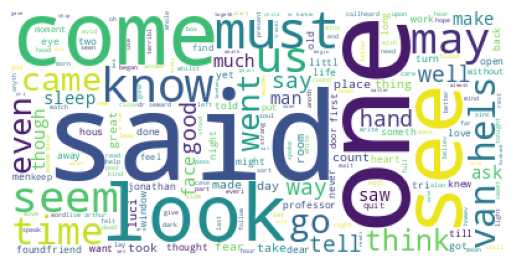

In [ ]:
Dracula= ' '.join(dwords['stem'])
m_wordcloud = WordCloud(background_color="white", max_font_size=100).generate(Dracula)
plt.imshow(m_wordcloud)
plt.axis("off")

In [ ]:
fwords = ppwords[(ppwords['book'] == 'Frankenstein.txt')]
fwords

,book,line,word,stem
219,Frankenstein.txt,72,letter,letter
222,Frankenstein.txt,74,mrs,mr
223,Frankenstein.txt,74,saville,savil
224,Frankenstein.txt,74,england,england
225,Frankenstein.txt,77,st,st
...,...,...,...,...
75184,Frankenstein.txt,7386,away,away
75187,Frankenstein.txt,7386,waves,wave
75189,Frankenstein.txt,7387,lost,lost
75191,Frankenstein.txt,7387,darkness,dark


(-0.5, 399.5, 199.5, -0.5)

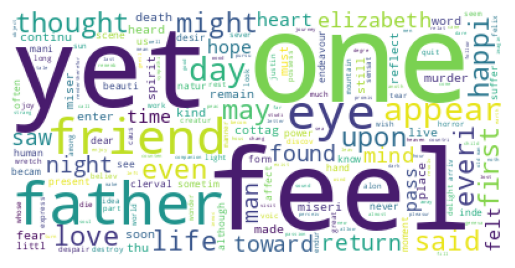

In [ ]:

Frankenstein = ' '.join(fwords['stem'])
m_wordcloud = WordCloud(background_color="white", max_font_size=100).generate(Frankenstein)
plt.imshow(m_wordcloud)
plt.axis("off")